In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
from numpy import linalg

In [2]:
import geopandas as gpd

In [3]:
import seaborn as sns
sns.set(style="whitegrid")

In [4]:
def geoplot(df, variable, title=None, cmap='YlGn', save=None):
    umax = df[variable].max()
    umin = df[variable].min()

    fig, ax = plt.subplots(1, figsize=(8, 6), dpi=150)
    df.plot(column=variable, cmap=cmap, ax=ax, linewidth=0.125, edgecolor='0.0')
    ax.axis('off')

    sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(vmin=umin, vmax=umax))
    sm._A = []
    cbar = fig.colorbar(sm)
    
    if title is not None:
        plt.title(title)

    if save is not None:
        plt.savefig(save, figsize=(8,6), dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [5]:
def corrplot(data, x, y, xlim=None, ylim=None, xlabel=None, ylabel=None, save=None, quantiles=False):
    df = data.copy()
    if quantiles:
        df[x] = df[x].rank(method="average", pct=True)
        df[y] = df[y].rank(method="average", pct=True)
        
    if xlim is None:
        xmin = df[x].min()
        xmax = df[x].max()
        xlim = (xmin,xmax)
    
    if ylim is None:
        ymin = df[y].min()
        ymax = df[y].max()
        ylim = (ymin,ymax)
    
    g = sns.jointplot(x, y, data=df,
                      kind="reg", truncate=False,
                      xlim=xlim, ylim=ylim,
                      height=7, space=1)
    
    if xlabel is not None:
        plt.xlabel(xlabel)
        
    if ylabel is not None:
        plt.ylabel(ylabel)
        
    r, p = stats.pearsonr(data[x],data[y])
    p_str = f'= {p:.5f}' if p >= 1E-5 else "< 0.00001"
    plt.title(f"$r^2 = {r**2:.5f}$, $p {p_str}$", y=1.3, fontsize = 16)
        
    if save is not None:
        plt.savefig(save, figsize=(8,8), dpi=300, bbox_inches="tight")
    else:
        plt.show()

In [6]:
def corrfit(data, X, Y, xlabel=None, ylabel=None, log=(False, False), xlim=None, ylim=None, size=None):
    df = data.loc[:,[X,Y]]

    if log[0]:
        U = f"log({X})"
        xlabel = f"log: {xlabel}"
        df[U] = df[X].map(np.log)
    else:
        U = X

    if log[1]:
        V = f"log({Y})"
        ylabel = f"log: {ylabel}"
        df[V] = df[Y].map(np.log)
    else:
        V = Y

    r = stats.linregress(df[U], df[V])
    df['fit'] = (r.intercept + r.slope*df[U])
    df['residuals'] = df[V]  - df.fit
    df['scaled_residuals'] = df.residuals/df.fit

    dfBULK = df[df.scaled_residuals.abs() <= 2*df.scaled_residuals.std()]
    dfOUT = df[df.scaled_residuals.abs() > 2*df.scaled_residuals.std()]

    if xlim is None:
        xmin = df[U].min()
        xmax = df[U].max()
        xwidth = xmax - xmin
        xmax = xmax + 0.05*xwidth
        xmin = xmin - 0.05*xwidth
        xlim = (xmin,xmax)

    if ylim is None:
        ymin = df[V].min()
        ymax = df[V].max()
        ywidth = ymax - ymin
        ymax = ymax + 0.05*ywidth
        ymin = ymin - 0.05*ywidth
        ylim = (ymin,ymax)

    #print(size, data.columns)
    if size is not None:
        if size not in df.columns:
            if size not in data.columns:
                size = None
            else:
                df[size] = data[size]
    #print('Size:', size, df[size].min(), df[size].max())
        
    df['Outlier'] = df.scaled_residuals.abs() > 2*df.scaled_residuals.std()

    g0 = sns.jointplot(U, V, data=dfBULK,
                      kind="reg", 
                      marker="o",
                      xlim=xlim, ylim=ylim,
                      scatter=False,
                      height=7)    
    g1 = sns.scatterplot(U, V, data=df, hue="Outlier",
                         size=size, sizes=(25,200),
                         alpha=0.75, 
                         marker="o", edgecolor="k",
                         ax=g0.ax_joint)
    #g2 = sns.scatterplot(U, V, data=dfOUT, size="dPOP",
    #                    color="orange", marker="o", edgecolor="k",
    #                    ax=g0.ax_joint)

    if xlabel is not None:
        plt.xlabel(xlabel)

    if ylabel is not None:
        plt.ylabel(ylabel)

    r, p = stats.pearsonr(dfBULK[U],dfBULK[V])
    p_str = f'= {p:.5f}' if p >= 1E-5 else "< 0.00001"
    plt.title(f"$r^2 = {r**2:.5f}$, $p {p_str}$", pad=-5, fontsize = 12)
    plt.show()
    
    return stats.linregress(dfBULK[U], dfBULK[V])

In [9]:
u = gpd.read_file("uk_covid.geojson").set_index("code")
d = pd.read_csv('uk_demographics.csv').set_index('code').loc[:,['0-29','30-59','60-89']]
uk = u.join(d)

In [10]:
def scale(X):
    return (X - X.mean())/X.std()

Eigenvalues [7.22928677e+00 3.08659118e+00 1.23234076e+00 8.98065955e-01
 5.93101939e-01 3.73348974e-01 1.87024050e-01 1.36966261e-01
 1.17514700e-01 1.66164558e-04 1.27750045e-02 2.07443953e-02
 6.28805799e-02 4.91932664e-02]
PCA0:  0.6283212920590429 2.167570145175589e-20


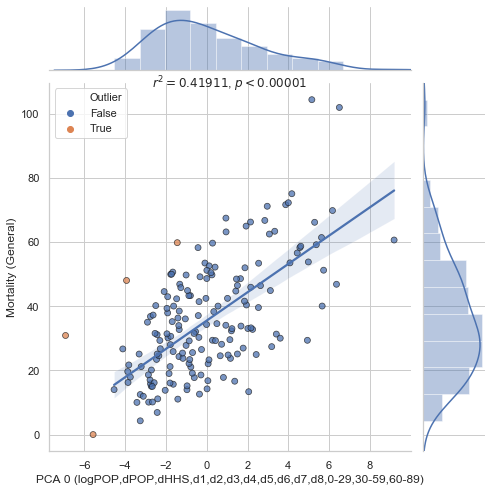

PCA1:  0.011899794755274973 0.8765153021993498
PCA2:  0.2793515036973779 0.00019762410394774663


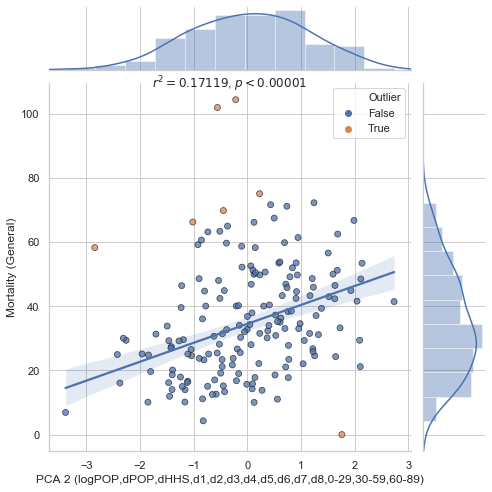

PCA3:  0.0376602016652724 0.6227715413315119
PCA4:  -0.04053491045255732 0.5964544306947982
PCA5:  -0.28744274712363505 0.00012579236972183694


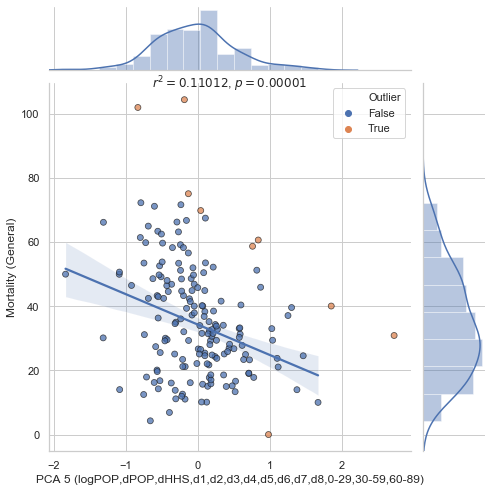

PCA6:  -0.14164054094332276 0.06304593267682335


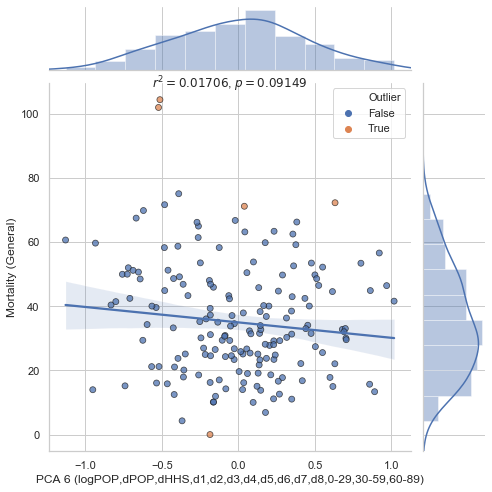

PCA7:  0.19600925496577332 0.009751195511226817


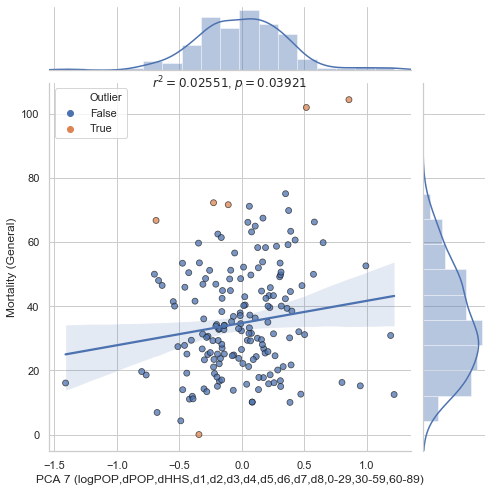

PCA8:  -0.13427419665987175 0.07819057655823963


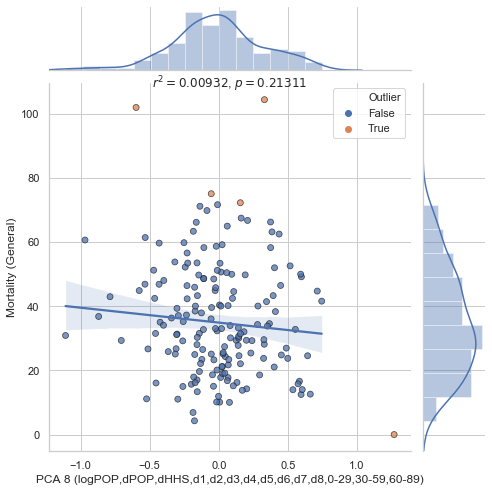

PCA9:  0.0027286319643108417 0.971577840034854
PCA10:  0.02519768564357346 0.7421002159263261
PCA11:  -0.02687457577441787 0.7256028364405886
PCA12:  0.10829277658018274 0.15612732723806308


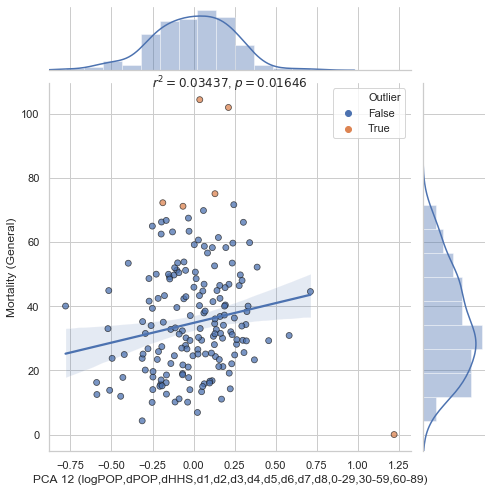

PCA13:  0.08603032745852152 0.260403929587837
['PCA0', 'PCA2', 'PCA5', 'PCA6', 'PCA7', 'PCA8', 'PCA12']


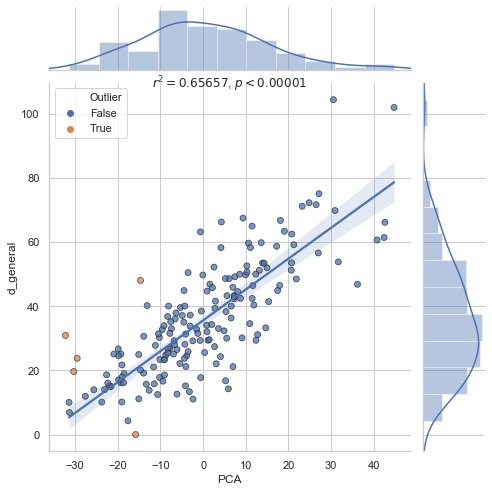

LinregressResult(slope=0.9611147508394207, intercept=35.579651576539, rvalue=0.8102918630339209, pvalue=2.2673413116062992e-40, stderr=0.053950689589140274)


logPOP     1.961284
dPOP       5.337402
dHHS      -1.657700
d1         1.354433
d2       -13.541053
d3         5.552871
d4         4.356153
d5        -3.245057
d6        -3.507131
d7        -1.135322
d8         7.094446
0-29      -5.389344
30-59      1.863873
60-89      3.273516
dtype: float64

In [11]:
df = uk.loc[:,['population','dPOP','dHHS','1','2','3','4','5','6','7','8','households',"d_general", "0-29", "30-59", "60-89"]].copy()
df['logPOP'] = scale(df['population'].map(np.log))
df['dPOP'] = scale((df['dPOP']).map(np.log))
df['dHHS'] = scale(df['dHHS'])
df['0-29'] = scale(df['0-29'])
df['30-59'] = scale(df['30-59'])
df['60-89'] = scale(df['60-89'])
df['d1'] = scale((df['1']/df['households']).map(np.log))
df['d2'] = scale((df['2']/df['households']).map(np.log))
df['d3'] = scale((df['3']/df['households']).map(np.log))
df['d4'] = scale((df['4']/df['households']).map(np.log))
df['d5'] = scale((df['5']/df['households']).map(np.log))
df['d6'] = scale((df['6']/df['households']).map(np.log))
df['d7'] = scale((df['7']/df['households']).map(np.log))
df['d8'] = scale((df['8']/df['households']).map(np.log))

factors = ['logPOP','dPOP','dHHS','d1','d2','d3','d4','d5','d6','d7','d8',"0-29", "30-59", "60-89"]
C = df.loc[:,factors].corr().to_numpy()
e, v = linalg.eig(C)

print("Eigenvalues", e)
results = {}
results['components'] = factors
results['eigenvalues'] = e

components = []
for i in range(len(e)):
    df[f'PCA{i}'] = (df.loc[:,factors]*v[:,i]).sum(axis=1)    
    r, p = stats.pearsonr(df[f'PCA{i}'],df["d_general"])
    print(f"PCA{i}: ", r, p)
    if p < 0.1 or np.abs(r) > 0.1:    
        regress = corrfit(df, X=f'PCA{i}', Y="d_general", 
                        xlabel=f"PCA {i} ({','.join(factors)})", ylabel="Mortality (General)", 
                        log=(False, False))
        results[f'PCA{i}'] = {
            'eigenvector': v[:,i],
            'fit': regress
        }
        components.append(f'PCA{i}')

print(components)
df['PCA'] = 0
weights = np.zeros_like(results['PCA0']['eigenvector'])
for pca in components:
    df['PCA'] += results[pca]['fit'].slope*df[pca]
    weights += results[pca]['fit'].slope*results[pca]['eigenvector']
r = corrfit(df,'PCA','d_general')
df["PCR"] = r.intercept + r.slope*df["PCA"]
print(r)
data = df.copy()
pd.Series(weights, index=results['components'])


In [12]:
df = data
df["error"] = (df["d_general"] - df["PCR"])
df["perror"] = (df["error"]/df["PCR"]).round(3)*100
df.loc[:,["population","PCA","PCR","d_general","error","perror"]].sort_values("perror")

,population,PCA,PCR,d_general,error,perror
code,,,,,,
E06000053,2224.0,-15.819275,20.375513,0.000000,-20.375513,-100.0
W06000001,70043.0,-17.625533,18.639492,4.283083,-14.356409,-77.0
W06000006,135957.0,-2.368742,33.303019,11.032900,-22.270119,-66.9
E06000010,259778.0,5.920479,41.269911,14.242931,-27.026981,-65.5
E06000031,202259.0,-3.223737,32.481270,13.349221,-19.132050,-58.9
...,...,...,...,...,...,...
E06000017,39927.0,-31.427134,5.374570,10.018283,4.643714,86.4
E10000006,500012.0,-14.679071,21.471380,47.998848,26.527468,123.5
W06000023,132435.0,-30.329070,6.429935,19.632272,13.202338,205.3


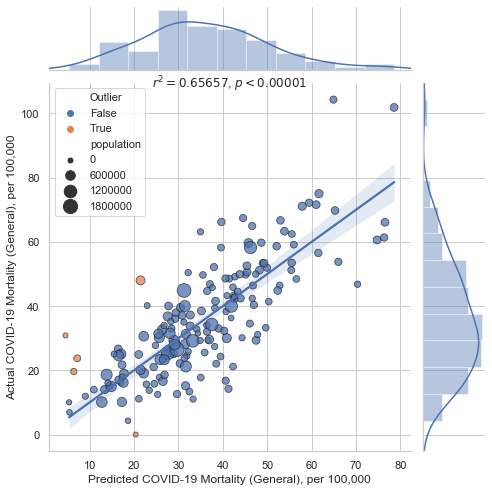

LinregressResult(slope=1.0000000000000004, intercept=-1.4210854715202004e-14, rvalue=0.8102918630339212, pvalue=2.2673413116060084e-40, stderr=0.05613345289105246)

In [13]:
corrfit(df, X="PCR", Y="d_general",
        xlabel="Predicted COVID-19 Mortality (General), per 100,000",
        ylabel="Actual COVID-19 Mortality (General), per 100,000",
        log=(False,False), size="population")